## Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

### Model definitions
Define this notebooks "initializer model" (pretrained parameters and itos mapping) and the output model as well.

In [4]:
model_name = '4.2-Clas-108k-lines'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

init_model_name = '4.1-LM-108k-lines'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')
INIT_MODEL_PATH.mkdir(exist_ok=True)

### Tokenization
To create the model's tokens with the correct train-test split, run the code below. Only needed once on the notebook's first ever run.

In [5]:
MODEL_FIRST_RUN = False

In [6]:
def tokenize_lyrics(lyrics, line_num=True):
    '''
    Tokenizes lyrics
    '''
    tk = nltk.tokenize.LineTokenizer(blanklines='keep')
    tokd = tk.tokenize(lyrics)
    
    re_tk = nltk.tokenize.RegexpTokenizer(r'\[[^\]]+\]|\w+|[\d\.,]+|\S+',
                                          discard_empty=False)
    re_tokd = re_tk.tokenize_sents(tokd)
    
    if line_num:
        [s.insert(0, f'xBOL {line_num+1}') for line_num, s in enumerate(re_tokd)] # insert start token for each line
    else:
        [s.insert(0, f'xBOL') for s in re_tokd] # insert start token for each line

    [s.append('xEOL') for s in re_tokd] # append end token for each line
    
    flat = list(itertools.chain(*re_tokd))
    flat.insert(0, 'xBOS')
    flat.append('xEOS')
    # lower case and de-space
    flat = [w.lower().replace(' ', '-') for w in flat]
    return flat

In [7]:
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [8]:
def combine_tag(X, tag_list):
    """
    Apply heuristic for genre tagging. Some genres take priority, even if
        it doesn't appear in tag1. e.g. 'christian' is highly distinguishable
    
    1. if all tags are missing set to 'missing'
    2. if any of the three tags are 'foreign' set to 'foreign'
    2. if any of the three tags are 'christian', set to 'christian'
    3. if any of the three tags are 'country', set to 'country'
    4. if any of the three tags are 'instrumental' set to 'instrumental'
    5. if any of the three tags are 'christmas' set to 'christmas'
    6. check membership in top tag list starting with tag1 as priority.
       top tags are constructed after consolidation
    7. All else is set to "other"
    
    """
    if pd.isnull([X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]).all():
        return 'missing'
    elif 'foreign' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'foreign'
    elif 'christian' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'christian'
    elif 'country' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'country'
    elif 'instrumental' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'instrumental'
    elif 'christmas' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'christmas'
    elif X.mapped_tag1 in tag_list:
        return X.mapped_tag1
    elif X.mapped_tag2 in tag_list:
        return X.mapped_tag2
    elif X.mapped_tag3 in tag_list:
        return X.mapped_tag3
    else:
        return 'other'
    
def map_tag(df, genre_map, tag_list):
    """
    Pass in genre tag column(s) to get mapped genre tag
    """
    num_columns = df.shape[1]
    assert all([w.startswith('tag') for w in df.columns]),"check tag columns"
    series_out = df.copy()
    for i in range(1, num_columns+1):
        series_out = pd.merge(series_out, genre_map, how='left',
                              left_on=f'tag{i}', right_on='tag',
                              validate='m:1')
        series_out.loc[series_out.mapped_tag.isnull(), 'mapped_tag'] = series_out[f'tag{i}']
        series_out.drop(columns='tag', inplace=True)
        series_out.rename(columns={'mapped_tag': f'mapped_tag{i}'}, inplace=True)
        
    series_out = series_out.iloc[:, -num_columns:]
        
    combined_out = series_out.apply(combine_tag, axis=1, tag_list=tag_list)
        
    return pd.DataFrame(combined_out)

In [9]:
def process_tokens_and_genre(model_path):
    '''
    500k link: https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv
    108k link: https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv
    '''
    model_path = Path(model_path)
    model_path.mkdir(exist_ok=True)

    tags_and_lyrics_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics_tags.csv'


    # load scraped data
    df = pd.read_csv(tags_and_lyrics_url, index_col=0)

    # only keep lyrics with length < 5000
    df = df[df.lyrics.str.len() < 5000]
    print('Tokenizing...')
    df['tokd'] = df.lyrics.apply(tokenize_lyrics, line_num=True)
    df['tokd_len'] = df.tokd.apply(len)


    ### GENRE FEATURE ENGINEERING
    # bring in manual consolidation file
    genre_map = pd.read_excel('../data/external/genre_tag_mapping.xlsx', header=None,
                             names=['tag', 'mapped_tag'], usecols=[0,4], skiprows=1)
    genre_map.loc[genre_map['mapped_tag'].isnull(), 'mapped_tag'] = genre_map['tag']

    # come up with top 20 based on conslidated
    top_tags = pd.read_excel('../data/external/genre_tag_mapping.xlsx', header=None,
                             names=['tag', 'tag1', 'tag2', 'combined', 'mapped_tag'],
                             skiprows=1)
    top_tags.loc[top_tags['mapped_tag'].isnull(), 'mapped_tag'] = top_tags['tag']
    top_tags = top_tags.groupby('mapped_tag')\
        .sum().sort_values('combined', ascending=False)
    tag_list = set(top_tags.head(20).index)

    tag_feat = FunctionTransformer(map_tag, validate=False,
                               kw_args={'genre_map': genre_map,
                                        'tag_list': tag_list})

    genre_transformer_text = Pipeline(steps=[
        ('tagger', tag_feat)
    ])


    preprocessor_text = ColumnTransformer(
        transformers=[
            ('genre', genre_transformer_text, genre_features)
        ],
        remainder='drop'
    )

    genres = pd.DataFrame(preprocessor_text.fit_transform(df), columns=['genre'])
    full_df = pd.concat([df, genres], axis=1)

    sub_df = full_df[(full_df['genre'] != 'missing') & (full_df['genre'] != 'other')]

    df_train, df_valid = train_test_split(sub_df, test_size=0.2, random_state=2018)

    encoder = ModifiedLabelEncoder()
    train_labels = encoder.fit_transform(df_train['genre'])
    valid_labels = encoder.transform(df_valid['genre'])

    # tokens
    print('Saving...')
    tokens = np.array(df_train.tokd)
    np.save(MODEL_PATH/'train_tok.npy', tokens)

    tokens = np.array(df_valid.tokd)
    np.save(MODEL_PATH/'valid_tok.npy', tokens)

    #labels
    np.save(MODEL_PATH/'train_lbl.npy', list(itertools.chain(*train_labels)))
    np.save(MODEL_PATH/'valid_lbl.npy', list(itertools.chain(*valid_labels)))
    print('Done.')


In [10]:
if MODEL_FIRST_RUN:
    process_tokens_and_genre(MODEL_PATH)

TESTING

In [89]:
tags_and_lyrics_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics_tags.csv'


# load scraped data
df = pd.read_csv(tags_and_lyrics_url, index_col=0)

# only keep lyrics with length < 5000
df = df[df.lyrics.str.len() < 5000]
print('Tokenizing...')
df['tokd'] = df.lyrics.apply(tokenize_lyrics, line_num=True)
df['tokd_len'] = df.tokd.apply(len)


### GENRE FEATURE ENGINEERING
# bring in manual consolidation file
genre_map = pd.read_excel('../data/external/genre_tag_mapping.xlsx', header=None,
                         names=['tag', 'mapped_tag'], usecols=[0,4], skiprows=1)
genre_map.loc[genre_map['mapped_tag'].isnull(), 'mapped_tag'] = genre_map['tag']

# come up with top 20 based on conslidated
top_tags = pd.read_excel('../data/external/genre_tag_mapping.xlsx', header=None,
                         names=['tag', 'tag1', 'tag2', 'combined', 'mapped_tag'],
                         skiprows=1)
top_tags.loc[top_tags['mapped_tag'].isnull(), 'mapped_tag'] = top_tags['tag']
top_tags = top_tags.groupby('mapped_tag')\
    .sum().sort_values('combined', ascending=False)
tag_list = set(top_tags.head(20).index)

tag_feat = FunctionTransformer(map_tag, validate=False,
                           kw_args={'genre_map': genre_map,
                                    'tag_list': tag_list})

genre_transformer_text = Pipeline(steps=[
    ('tagger', tag_feat)
])


preprocessor_text = ColumnTransformer(
    transformers=[
        ('genre', genre_transformer_text, genre_features)
    ],
    remainder='drop'
)

genres = pd.DataFrame(preprocessor_text.fit_transform(df), columns=['genre'])
full_df = pd.concat([df, genres], axis=1)

sub_df = full_df[(full_df['genre'] != 'missing') & (full_df['genre'] != 'other')]

df_train, df_valid = train_test_split(sub_df, test_size=0.2, random_state=2018)

encoder = ModifiedLabelEncoder()
train_labels = encoder.fit_transform(df_train['genre'])
valid_labels = encoder.transform(df_valid['genre'])

# tokens
print('Saving...')
tokens = np.array(df_train.tokd)
np.save(MODEL_PATH/'train_tok.npy', tokens)

tokens = np.array(df_valid.tokd)
np.save(MODEL_PATH/'valid_tok.npy', tokens)

#labels
np.save(MODEL_PATH/'train_lbl.npy', list(itertools.chain(*train_labels)))
np.save(MODEL_PATH/'valid_lbl.npy', list(itertools.chain(*valid_labels)))
print('Done.')


## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our classifier further or generate text with a pre-trained LM.

In [25]:
if MODEL_FIRST_RUN:
    data_clas = TextClasDataBunch.from_tokens(MODEL_PATH,
                                            bs=128,
                                            max_vocab=10000)

Numericalizing train.
Numericalizing valid.


In [26]:
if not MODEL_FIRST_RUN:
    data_clas = TextClasDataBunch.from_id_files(MODEL_PATH/'tmp')
    data_clas.path = MODEL_PATH

In [27]:
data_clas.train_ds.vocab_size

10002

## Model setup

In [28]:
GPU = True
DOWNLOAD_INIT_MODEL = False

In [29]:
def text_classifier_learner(data:DataBunch, bptt:int=70, emb_sz:int=400, nh:int=1150, nl:int=3, pad_token:int=1,
               drop_mult:float=1., qrnn:bool=False,max_len:int=10*70, lin_ftrs:Collection[int]=None,
               ps:Collection[float]=None, **kwargs) -> 'TextClassifierLearner':
    "Create a RNN classifier."
    dps = default_dropout['classifier'] * drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]
    ds = data.train_ds
    vocab_size, n_class = len(data.vocab.itos), len(np.unique(data.train_ds.labels))
    layers = [emb_sz*3] + lin_ftrs + [n_class]
    ps = [dps[4]] + ps
    model = get_rnn_classifier(bptt, max_len, n_class, vocab_size, emb_sz, nh, nl, pad_token,
                layers, ps, input_p=dps[0], weight_p=dps[1], embed_p=dps[2], hidden_p=dps[3], qrnn=qrnn)
    learn = RNNLearner(data, model, bptt, split_func=rnn_classifier_split, **kwargs)
    return learn

default_dropout = {'language': np.array([0.25, 0.1, 0.2, 0.02, 0.15]),
                   'classifier': np.array([0.4,0.5,0.05,0.3,0.4])}

In [30]:
def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the f_beta between preds and targets"
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [42]:
learn = text_classifier_learner(data_clas, drop_mult=0.5, metrics=[fbeta])

In [43]:
# weights_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'
# itos_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'

# if DOWNLOAD_INIT_MODEL:
#     Path(MODEL_PATH/'models').mkdir(exist_ok=True)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)

In [44]:
if DOWNLOAD_INIT_MODEL:
    untar_data('https://s3.amazonaws.com/fast-ai-modelzoo/wt103',
               dest=MODEL_PATH/'models'/f'{init_model_name}')
    
    # trained weights
    with open(MODEL_PATH/'models'/f'{model_name}_best.pth', 'wb') as f:
        res = requests.get(f'https://storage.googleapis.com/w210-capstone/models/{model_name}_best.pth')
        f.write(res.content)

**Create a folder in this model's directory with the name of the initializer model. In that folder, copy a .pth file in the form lstm_<init_model_name>.pth and a .pkl file in the form itos_<init_model_name>.pkl' in order to transfer weights and tokens correctly from the initializer model**

In [36]:
if MODEL_FIRST_RUN:
    learn.load_pretrained(MODEL_PATH/f'{init_model_name}/lstm_{init_model_name}.pth', 
                          MODEL_PATH/f'{init_model_name}/itos_{init_model_name}.pkl')

In [37]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [38]:
if not MODEL_FIRST_RUN:
    if not GPU:
        learn.cpu_load(f'{model_name}_best')
    else:
        learn.load(f'{model_name}_best')

## Training

In [45]:
TRAIN = True

In [46]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [47]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [48]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

Total time: 35:34
epoch  train_loss  valid_loss  accuracy
1      2.771330    12.827343   0.170142  (35:34)



In [49]:
if TRAIN:
    learn.unfreeze()
    learn.fit(1, 1e-3, callbacks=[save_callback])

Total time: 35:46
epoch  train_loss  valid_loss  accuracy
1      2.780451    2.777184    0.172278  (35:46)



In [50]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.7771838


In [55]:
learn.pred_batch()

AttributeError: 'tuple' object has no attribute 'detach'

In [30]:
#learn.save_encoder(f'{model_name}_encoder')

### Learning Loss

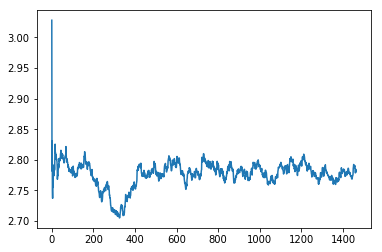

In [51]:
if TRAIN:
    learn.recorder.plot_losses()

### Model Output

In [32]:
if TRAIN:
    MODEL_OUTPUT_NAME = MODEL_PATH/'models'/f'{model_name}_best.pth'
    CLOUD_STORAGE = f'gs://w210-capstone/models/{model_name}_best.pth'

In [33]:
!gsutil cp $MODEL_OUTPUT_NAME $CLOUD_STORAGE

Copying file://../data/models/4.1-LM-108k-lines/models/4.1-LM-108k-lines_best.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/150.5 MiB.                                    


In [60]:
ARCHITECTURE_PATH = MODEL_PATH/'models'/f'{model_name}_architecture.pkl'
ARCHITECTURE_STORAGE = f'gs://w210-capstone/models/{model_name}_architecture.pkl'
ITOS_PATH = MODEL_PATH/'tmp'/'itos.pkl'
ITOS_STORAGE = f'gs://w210-capstone/models/{model_name}_itos.pkl'

model_dump = learn.model
with open(ARCHITECTURE_PATH, 'wb') as f:
    pickle.dump(model_dump, f)

In [58]:
!gsutil cp $ARCHITECTURE_PATH $ARCHITECTURE_STORAGE

Copying file://../data/models/4.1-LM-108k-lines/models/4.1-LM-108k-lines_architecture.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/335.3 MiB.                                    


In [61]:
!gsutil cp $ITOS_PATH $ITOS_STORAGE

Copying file://../data/models/4.1-LM-108k-lines/tmp/itos.pkl [Content-Type=application/octet-stream]...
/ [1 files][310.1 KiB/310.1 KiB]                                                
Operation completed over 1 objects/310.1 KiB.                                    
